*Objetivo:* Anticipar la probabilidad de materialización de un riesgo en los próximos 30 días, 
a partir de señales tempranas detectadas en los datos históricos.

1. Importar librerías

In [113]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Persistencia de modelos y tracking
import joblib
import mlflow
import mlflow.sklearn
import pickle

# Manejo de fechas
from datetime import timedelta

# Preprocesamiento y escalamiento
from sklearn.preprocessing import LabelEncoder, StandardScaler

# División y entrenamiento del modelo
from sklearn.model_selection import train_test_split

# Modelos de machine learning
from sklearn.ensemble import RandomForestClassifier

# Métricas y evaluación
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)

# Balanceo de clases (dataset desbalanceado)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Soporte para exportar resultados
from openpyxl import Workbook

# Configuración general
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Verificación de entorno
print("Librerías importadas correctamente ✅")


Librerías importadas correctamente ✅


2. Cargar datos

In [114]:
# Ruta del archivo de datos
ruta_datos = r"C:\Users\Valentina Molina\Documents\repositorios\Proyecto_II\datos\Bas_de_datos_riesgos_original_30.09.2025.xlsx"

# Cargar el dataset
df = pd.read_excel(ruta_datos)

# Confirmar carga y dimensiones
print(f"✅ Datos cargados correctamente desde:\n{ruta_datos}")
print(f"Registros: {df.shape[0]} | Columnas: {df.shape[1]}")

# Vista general de los primeros registros
display(df.head())

# Tipos de datos y valores nulos
print("\n📊 Información general del dataset:")
df.info()

print("\n🔍 Valores nulos por columna:")
print(df.isnull().sum())

print("📅 Rango de fechas de seguimiento:")
print(df["FechaSeguimiento_DT"].min(), "→", df["FechaSeguimiento_DT"].max())


✅ Datos cargados correctamente desde:
C:\Users\Valentina Molina\Documents\repositorios\Proyecto_II\datos\Bas_de_datos_riesgos_original_30.09.2025.xlsx
Registros: 10412 | Columnas: 32


,Proyecto_CD,Proyecto_DS,UEN_DS,NombreEmpleado_DS,ApellidoEmpleado_DS,Severidad_DS,Riesgo_CD,Estado_DS,Creacion_DT,Actualizacion_DT,...,FechaSeguimiento_DT,ObservacionSeguimiento_DS,CantidadSeguimientos_NM,EsfuerzoSeguimiento_NM,Periocidad_DS,Cliente_DS,PRY_REQUIERE_RIESGOS,Tipo_Proyecto,Metodologia,AgenteGenerador_DS
0,10468,ADM_PES_10468: FEMTI,Gasto Funcionamiento,HILDA MILENA,LUNA BOCANEGRA,NaN,NaN,NO VIGENTE,NaT,NaT,...,NaT,NaN,0,0,NaN,SETI S.A.S,S,ADMINISTRACIÓN,ZZ_NO ENCONTRADO,NaN
1,11051,ADM_GAF_11051: GASTOS TRANSPORTE,Gastos Adicionales,JORGE HUMBERTO,VALBUENA FARFAN,NaN,NaN,NO VIGENTE,NaT,NaT,...,NaT,NaN,0,0,NaN,SETI S.A.S,N,ADMINISTRACIÓN,ZZ_NO ENCONTRADO,NaN
2,11405,ADM_GTH_11405: GESTIÓN TALENTO HUMANO,Gestión Talento Humano,DIANA PATRICIA,SIERRA RODRIGUEZ,Riesgo Alto,5548.0,VIGENTE,2025-05-29 11:34:57,2025-06-27 09:40:27,...,2025-06-25,Se genero divulgación de la información al equ...,4,0,MENSUAL,SETI S.A.S,S,ADMINISTRACIÓN,ZZ_NO ENCONTRADO,Gerente de Servicio
3,11405,ADM_GTH_11405: GESTIÓN TALENTO HUMANO,Gestión Talento Humano,DIANA PATRICIA,SIERRA RODRIGUEZ,Riesgo Alto,5548.0,VIGENTE,2025-05-29 11:34:57,2025-06-27 09:40:27,...,2025-07-24,Se inició con el proceso de la debida diligenc...,4,0,MENSUAL,SETI S.A.S,S,ADMINISTRACIÓN,ZZ_NO ENCONTRADO,Gerente de Servicio
4,11405,ADM_GTH_11405: GESTIÓN TALENTO HUMANO,Gestión Talento Humano,DIANA PATRICIA,SIERRA RODRIGUEZ,Riesgo Alto,5548.0,VIGENTE,2025-05-29 11:34:57,2025-06-27 09:40:27,...,2025-08-13,Se inició con el proceso de escalamiento a la ...,4,0,MENSUAL,SETI S.A.S,S,ADMINISTRACIÓN,ZZ_NO ENCONTRADO,Gerente de Servicio



📊 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10412 entries, 0 to 10411
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Proyecto_CD                10412 non-null  int64         
 1   Proyecto_DS                10412 non-null  object        
 2   UEN_DS                     10412 non-null  object        
 3   NombreEmpleado_DS          10412 non-null  object        
 4   ApellidoEmpleado_DS        10412 non-null  object        
 5   Severidad_DS               10340 non-null  object        
 6   Riesgo_CD                  10340 non-null  float64       
 7   Estado_DS                  10412 non-null  object        
 8   Creacion_DT                10340 non-null  datetime64[ns]
 9   Actualizacion_DT           10340 non-null  datetime64[ns]
 10  CantidadSeveridad_NM       10412 non-null  int64         
 11  CantidadMaterializada_NM   1041

3. Limpieza de datos

In [115]:
for col in df.columns:
    print(col)

Proyecto_CD
Proyecto_DS
UEN_DS
NombreEmpleado_DS
ApellidoEmpleado_DS
Severidad_DS
Riesgo_CD
Estado_DS
Creacion_DT
Actualizacion_DT
CantidadSeveridad_NM
CantidadMaterializada_NM
Insercion_DT
ValorInterno_VR
ValorCliente_VR
NombreRiesgo_DS
Causa_DS
DetalleCausa_DS
Fuente_DS
DescripcionRiesgo_DS
FechaIdentificacion_DT
PlanAccion_DS
FechaSeguimiento_DT
ObservacionSeguimiento_DS
CantidadSeguimientos_NM
EsfuerzoSeguimiento_NM
Periocidad_DS
Cliente_DS
PRY_REQUIERE_RIESGOS
Tipo_Proyecto
Metodologia
AgenteGenerador_DS


In [116]:
# Eliminar columnas irrelevantes o redundantes
columnas_eliminar = [
    "Proyecto_DS", "UEN_DS", "NombreEmpleado_DS", "ApellidoEmpleado_DS",
    "Creacion_DT", "Actualizacion_DT", "CantidadSeveridad_NM", "Insercion_DT",
    "NombreRiesgo_DS", "Fuente_DS", "DescripcionRiesgo_DS", "FechaIdentificacion_DT",
    "PlanAccion_DS", "ObservacionSeguimiento_DS", "CantidadSeguimientos_NM",
    "EsfuerzoSeguimiento_NM", "Periocidad_DS", "Cliente_DS",
    "PRY_REQUIERE_RIESGOS", "Tipo_Proyecto", "Metodologia"
]
df = df.drop(columns=columnas_eliminar, errors='ignore')

In [117]:
# Filtrar solo riesgos vigentes
df = df[df["Estado_DS"] != "NO VIGENTE"]

In [118]:
# Convertir fechas a tipo datetime
df["FechaSeguimiento_DT"] = pd.to_datetime(df["FechaSeguimiento_DT"], errors="coerce")

# Crear columna 'Año'
df["Año"] = df["FechaSeguimiento_DT"].dt.year

# Filtrar desde 2023
df = df[df["Año"] >= 2023]

print(f"✅ Registros conservados desde 2023: {df.shape[0]}")
print(df["Año"].value_counts().sort_index())
print("📊 Estados disponibles:", df["Estado_DS"].unique())


✅ Registros conservados desde 2023: 7013
Año
2023.0     748
2024.0    1921
2025.0    4344
Name: count, dtype: int64
📊 Estados disponibles: ['VIGENTE']


In [119]:
columnas_categoricas=["Severidad_DS","Estado_DS","Causa_DS","DetalleCausa_DS", "AgenteGenerador_DS"]
df[columnas_categoricas]=df[columnas_categoricas].astype("category")

In [120]:
print("\nℹ️ Información final del dataset limpio:")
df.info()


ℹ️ Información final del dataset limpio:
<class 'pandas.core.frame.DataFrame'>
Index: 7013 entries, 2 to 10401
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Proyecto_CD               7013 non-null   int64         
 1   Severidad_DS              7013 non-null   category      
 2   Riesgo_CD                 7013 non-null   float64       
 3   Estado_DS                 7013 non-null   category      
 4   CantidadMaterializada_NM  7013 non-null   int64         
 5   ValorInterno_VR           7013 non-null   int64         
 6   ValorCliente_VR           7013 non-null   int64         
 7   Causa_DS                  7013 non-null   category      
 8   DetalleCausa_DS           5452 non-null   category      
 9   FechaSeguimiento_DT       7013 non-null   datetime64[ns]
 10  AgenteGenerador_DS        7013 non-null   category      
 11  Año                       7013 non-null   fl

In [121]:
df.to_excel("../datos/df_limpio_2023.xlsx", index=False)
print("💾 Dataset limpio guardado correctamente en la carpeta 'datos'.")

💾 Dataset limpio guardado correctamente en la carpeta 'datos'.


In [122]:
print(df["CantidadMaterializada_NM"].value_counts(normalize=True))

CantidadMaterializada_NM
0     0.856410
1     0.054328
2     0.036931
3     0.015970
5     0.014259
21    0.009126
16    0.003993
4     0.003422
6     0.003137
7     0.002424
Name: proportion, dtype: float64


4. Creación de nuevas variables

In [123]:
riesgos_materializados = (
    df.groupby("Riesgo_CD")
    .apply(lambda x: any((x["ValorInterno_VR"] > 0) | (x["ValorCliente_VR"] > 0)))
    .reset_index(name="alguna_vez_materializado")
)

df = df.merge(riesgos_materializados, on="Riesgo_CD", how="left")
df["materializado_global"] = np.where(df["alguna_vez_materializado"], 1, 0)

In [124]:
def marcar_materializacion_30d(grupo):
    fechas = grupo["FechaSeguimiento_DT"].values.astype('datetime64[ns]')
    interno = grupo["ValorInterno_VR"].fillna(0).values
    cliente = grupo["ValorCliente_VR"].fillna(0).values
    resultado = []
    
    for i, f in enumerate(fechas):
        fecha_limite = f + np.timedelta64(30, 'D')
        hay_evento = np.any(
            (fechas > f)
            & (fechas <= fecha_limite)
            & ((interno > 0) | (cliente > 0))
        )
        resultado.append(hay_evento)
    
    grupo["materializado_30d"] = resultado
    return grupo

df = df.groupby("Riesgo_CD", group_keys=False).apply(marcar_materializacion_30d)
df["materializado_30d"] = np.where(df["materializado_30d"], 1, 0)

In [125]:
df["valor_acumulado"] = df["ValorInterno_VR"].fillna(0) + df["ValorCliente_VR"].fillna(0)

In [126]:
df2 = df.dropna(subset=["FechaSeguimiento_DT", "Severidad_DS", "materializado_30d"])

# Convertir a categorías y binario
mapa_severidad = {
    "Riesgo Bajo": 1,
    "Riesgo Medio": 2,
    "Riesgo Significativo": 3,
    "Riesgo Alto": 4,
    "Riesgo Crítico": 5
}
df2["Severidad_NUM"] = df2["Severidad_DS"].map(mapa_severidad)
df2["materializado_30d"] = df2["materializado_30d"].astype(int)

In [127]:
# Frecuencia total de registros por riesgo
df2["conteo_registros_riesgo"] = df2.groupby("Riesgo_CD")["Riesgo_CD"].transform("count")

In [128]:
# Indica si la fila corresponde a la última fecha registrada del riesgo
df2["es_ultima_fecha"] = (
    df2.groupby("Riesgo_CD")["FechaSeguimiento_DT"]
    .transform(lambda x: x == x.max())
    .astype(int)
)

In [129]:
# Promedio del valor acumulado del riesgo a lo largo del tiempo
df2["promedio_valor"] = df2.groupby("Riesgo_CD")["valor_acumulado"].transform("mean")

In [130]:
print("Total de filas:", len(df2))
print("Total de columnas:", len(df2.columns))
print("Columnas nuevas:", [c for c in df2.columns if "valor" in c or "materializado" in c or "conteo" in c])

# Vista previa de los primeros registros
display(df2.head())

Total de filas: 7013
Total de columnas: 20
Columnas nuevas: ['alguna_vez_materializado', 'materializado_global', 'materializado_30d', 'valor_acumulado', 'conteo_registros_riesgo', 'promedio_valor']


,Proyecto_CD,Severidad_DS,Riesgo_CD,Estado_DS,CantidadMaterializada_NM,ValorInterno_VR,ValorCliente_VR,Causa_DS,DetalleCausa_DS,FechaSeguimiento_DT,AgenteGenerador_DS,Año,alguna_vez_materializado,materializado_global,materializado_30d,valor_acumulado,Severidad_NUM,conteo_registros_riesgo,es_ultima_fecha,promedio_valor
0,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-06-25,Gerente de Servicio,2025.0,False,0,0,0,4,3,0,0.0
1,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-07-24,Gerente de Servicio,2025.0,False,0,0,0,4,3,0,0.0
2,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-08-13,Gerente de Servicio,2025.0,False,0,0,0,4,3,1,0.0
3,11405,Riesgo Bajo,3592.0,VIGENTE,0,0,0,Legislación,Desconocimiento,2023-03-07,Proceso,2023.0,False,0,0,0,1,22,0,0.0
4,11405,Riesgo Bajo,3592.0,VIGENTE,0,0,0,Legislación,Desconocimiento,2023-04-03,Proceso,2023.0,False,0,0,0,1,22,0,0.0


5. Análisis descriptivo y gráfico

In [131]:
print("\n Resumen estadístico de variables numéricas:")
display(df2.select_dtypes(include=["number"]).describe().T)


 Resumen estadístico de variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Proyecto_CD,7013.0,12571.526023,414.129688,11405.0,12373.0,12758.0,12847.0,13052.0
Riesgo_CD,7013.0,4553.139598,809.282755,1979.0,4134.0,4789.0,5197.0,5707.0
CantidadMaterializada_NM,7013.0,0.552403,2.393957,0.0,0.0,0.0,0.0,21.0
ValorInterno_VR,7013.0,15731.076715,433598.713647,0.0,0.0,0.0,0.0,23555600.0
ValorCliente_VR,7013.0,8614.374447,344441.045860,0.0,0.0,0.0,0.0,19070000.0
Año,7013.0,2024.512762,0.680604,2023.0,2024.0,2025.0,2025.0,2025.0
materializado_global,7013.0,0.064167,0.245067,0.0,0.0,0.0,0.0,1.0
materializado_30d,7013.0,0.006987,0.083302,0.0,0.0,0.0,0.0,1.0
valor_acumulado,7013.0,24345.451162,585564.048685,0.0,0.0,0.0,0.0,24000000.0
conteo_registros_riesgo,7013.0,43.833880,61.409060,1.0,9.0,17.0,33.0,211.0


In [132]:
print("\n Resumen de variables categóricas:")
display(df2.select_dtypes(include=["category"]).describe().T)


 Resumen de variables categóricas:


,count,unique,top,freq
Severidad_DS,7013,5,Riesgo Significativo,3094
Estado_DS,7013,1,VIGENTE,7013
Causa_DS,7013,19,Seguridad,1944
DetalleCausa_DS,5452,19,Insuficiencia-Deficiencia,2978
AgenteGenerador_DS,7013,18,Recursos/Insumos/Tecnología,2240
Severidad_NUM,7013,5,3,3094


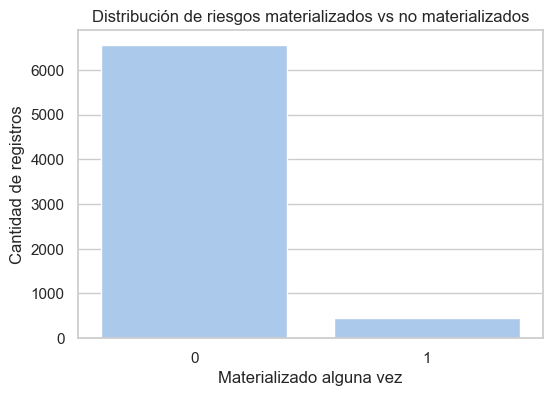

In [133]:
plt.figure(figsize=(6,4))
sns.countplot(x="materializado_global", data=df2)
plt.title("Distribución de riesgos materializados vs no materializados")
plt.xlabel("Materializado alguna vez")
plt.ylabel("Cantidad de registros")
plt.show()

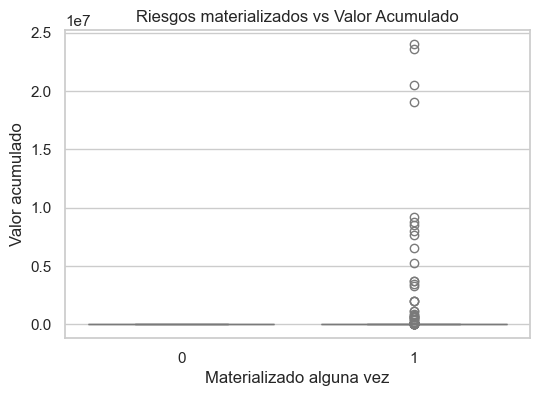

In [134]:
plt.figure(figsize=(6,4))
sns.boxplot(x="materializado_global", y="valor_acumulado", data=df2)
plt.title("Riesgos materializados vs Valor Acumulado")
plt.xlabel("Materializado alguna vez")
plt.ylabel("Valor acumulado")
plt.show()

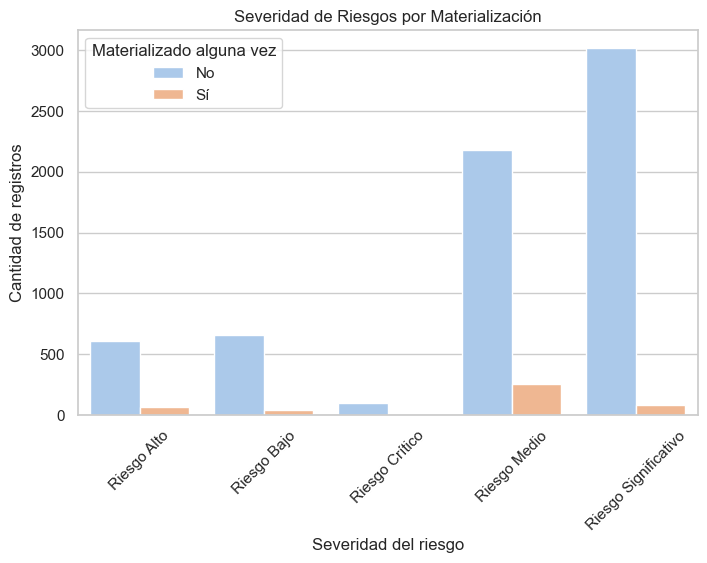

In [135]:
plt.figure(figsize=(8,5))
sns.countplot(x="Severidad_DS", hue="alguna_vez_materializado", data=df2)
plt.title("Severidad de Riesgos por Materialización")
plt.xticks(rotation=45)
plt.xlabel("Severidad del riesgo")
plt.ylabel("Cantidad de registros")
plt.legend(title="Materializado alguna vez", labels=["No", "Sí"])
plt.show()

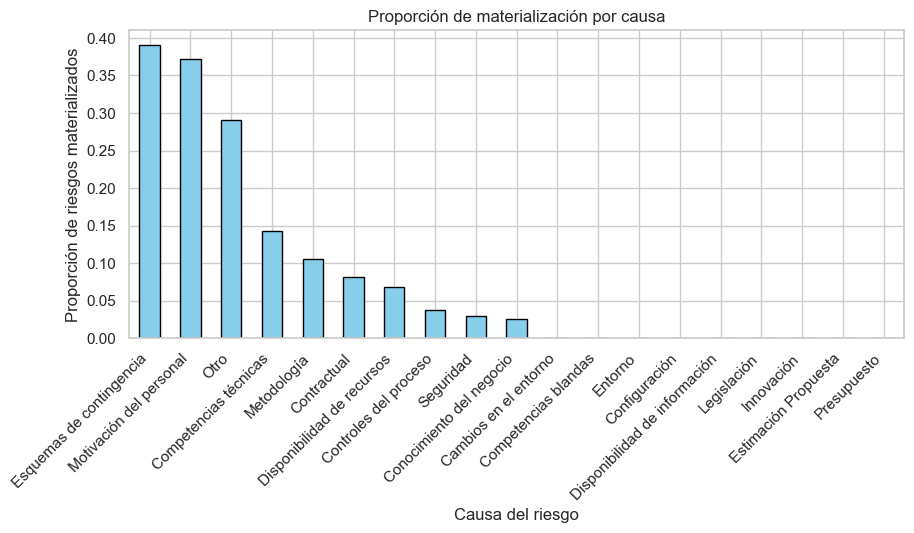

In [136]:
materializacion_por_causa = df2.groupby("Causa_DS")["materializado_global"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,4))
materializacion_por_causa.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Proporción de materialización por causa")
plt.ylabel("Proporción de riesgos materializados")
plt.xlabel("Causa del riesgo")
plt.xticks(rotation=45, ha="right")
plt.show()

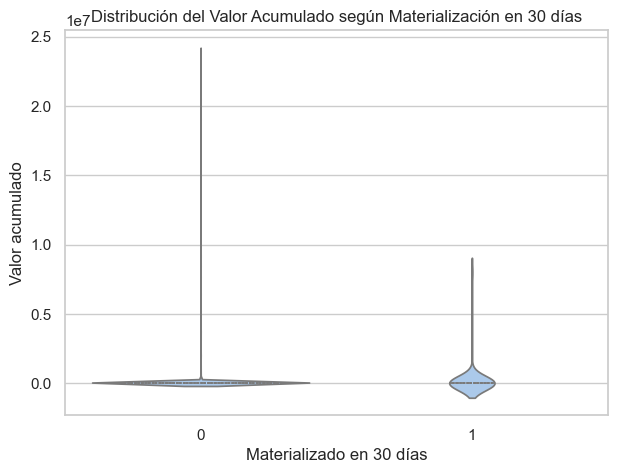

In [137]:
plt.figure(figsize=(7,5))
sns.violinplot(x="materializado_30d", y="valor_acumulado", data=df2, inner="quartile")
plt.title("Distribución del Valor Acumulado según Materialización en 30 días")
plt.xlabel("Materializado en 30 días")
plt.ylabel("Valor acumulado")
plt.show()

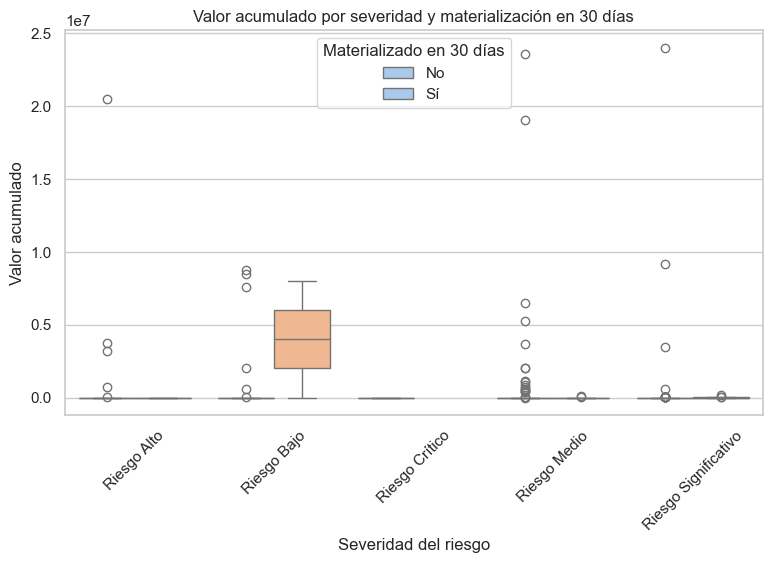

In [138]:
plt.figure(figsize=(9,5))
sns.boxplot(x="Severidad_DS", y="valor_acumulado", hue="materializado_30d", data=df2)
plt.title("Valor acumulado por severidad y materialización en 30 días")
plt.xlabel("Severidad del riesgo")
plt.ylabel("Valor acumulado")
plt.xticks(rotation=45)
plt.legend(title="Materializado en 30 días", labels=["No", "Sí"])
plt.show()

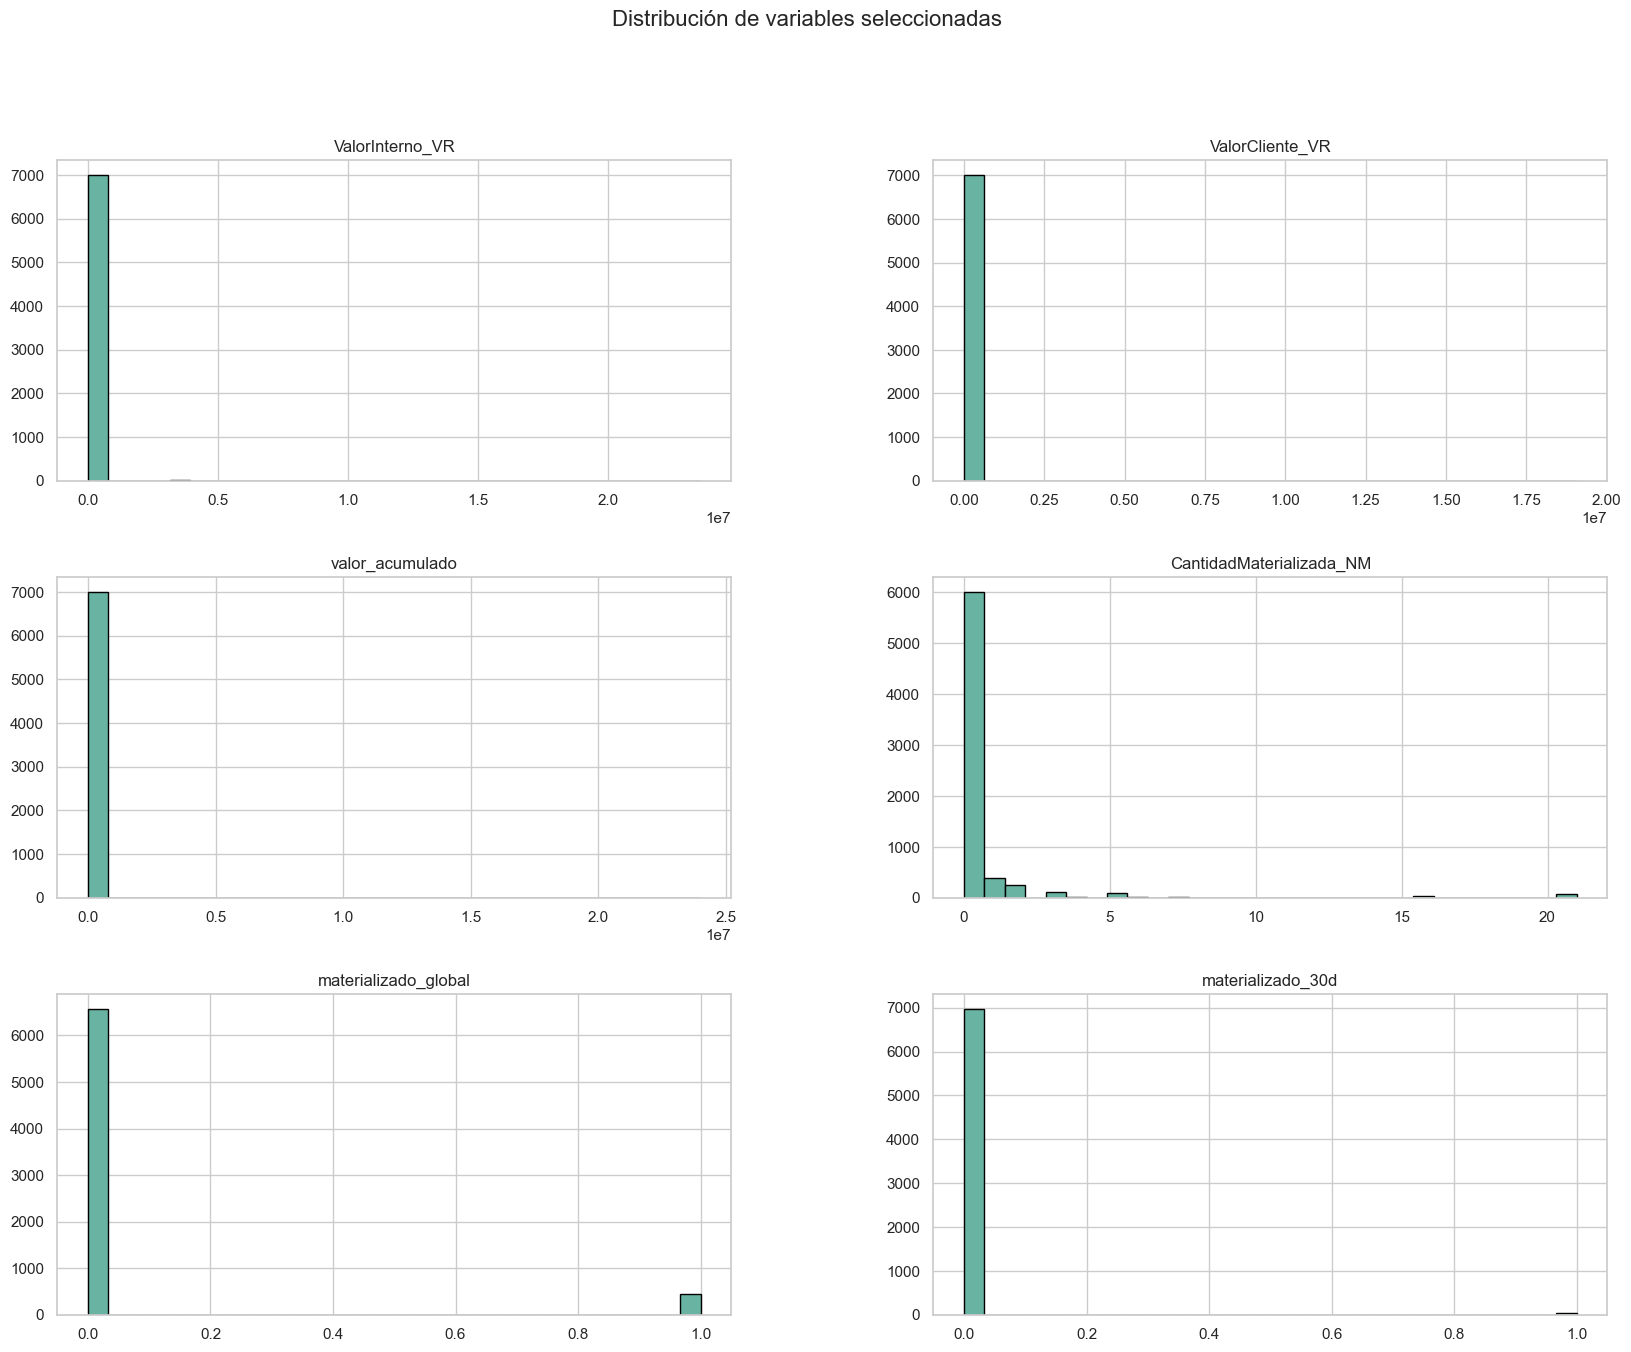

In [139]:
columnas = [
    "ValorInterno_VR",
    "ValorCliente_VR",
    "valor_acumulado",
    "CantidadMaterializada_NM",
    "materializado_global",
    "materializado_30d"
]

df2[columnas].hist(bins=30, figsize=(20,15), edgecolor="black", color="#69b3a2")
plt.suptitle("Distribución de variables seleccionadas", fontsize=16)
plt.show()

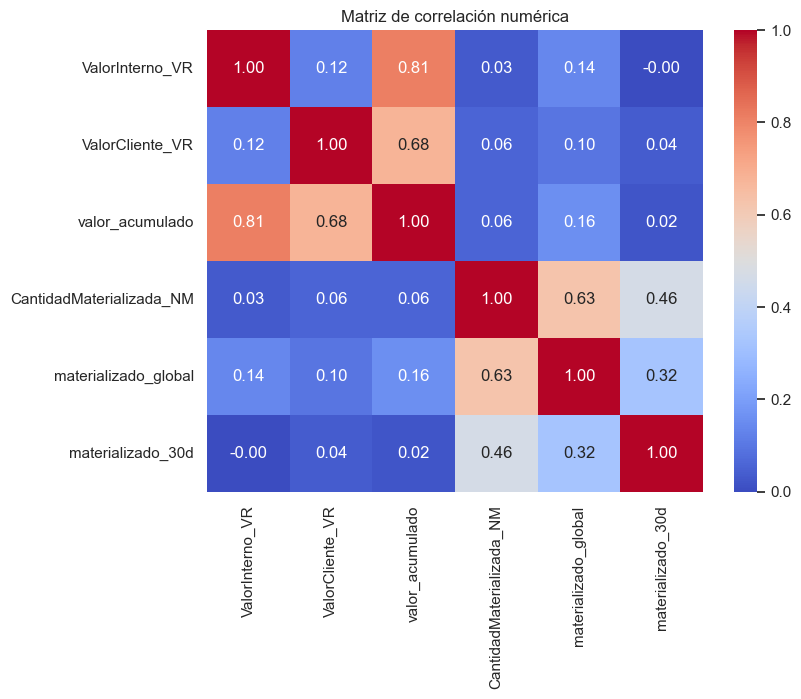

In [140]:
plt.figure(figsize=(8,6))
sns.heatmap(df2[columnas].corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación numérica")
plt.show()


6. División de datos

In [141]:
X = df2[["Severidad_NUM", "valor_acumulado"]]
y = df2["materializado_30d"]

In [142]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Distribución en y_train:")
print(y_train.value_counts(normalize=True))
print("Distribución en y_test:")
print(y_test.value_counts(normalize=True))

Tamaño del conjunto de entrenamiento: (5610, 2)
Tamaño del conjunto de prueba: (1403, 2)
Distribución en y_train:
materializado_30d
0    0.993048
1    0.006952
Name: proportion, dtype: float64
Distribución en y_test:
materializado_30d
0    0.992872
1    0.007128
Name: proportion, dtype: float64


7. Modelo Random Forest

7.1. Sin balanceo

In [143]:
modelo_rf = RandomForestClassifier(
    n_estimators=100,     
    random_state=42,      
    n_jobs=-1             
)

modelo_rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [144]:
y_pred = modelo_rf.predict(X_test)

In [145]:
print("Matriz de confusión (modelo sin balanceo):")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Matriz de confusión (modelo sin balanceo):
[[1392    1]
 [  10    0]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1393
           1       0.00      0.00      0.00        10

    accuracy                           0.99      1403
   macro avg       0.50      0.50      0.50      1403
weighted avg       0.99      0.99      0.99      1403



7.2. Balanceado en datos de entrenamiento y prueba en datos reales

7.2.1. Oversampling aleatorio

In [146]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print("Distribución después del oversampling:")
print(y_train_ros.value_counts())

Distribución después del oversampling:
materializado_30d
0    5571
1    5571
Name: count, dtype: int64


In [147]:
modelo_rf_ros = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
modelo_rf_ros.fit(X_train_ros, y_train_ros)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [148]:
y_pred_ros = modelo_rf_ros.predict(X_test)

In [149]:
print("\nMatriz de confusión (Oversampling aleatorio):")
print(confusion_matrix(y_test, y_pred_ros))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_ros, digits=3))


Matriz de confusión (Oversampling aleatorio):
[[1250  143]
 [   9    1]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.993     0.897     0.943      1393
           1      0.007     0.100     0.013        10

    accuracy                          0.892      1403
   macro avg      0.500     0.499     0.478      1403
weighted avg      0.986     0.892     0.936      1403



7.2.2. Smote

In [150]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Distribución después de aplicar SMOTE:")
print(y_train_sm.value_counts())

Distribución después de aplicar SMOTE:
materializado_30d
0    5571
1    5571
Name: count, dtype: int64


In [151]:
modelo_rf_sm = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
modelo_rf_sm.fit(X_train_sm, y_train_sm)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [152]:
y_pred_sm = modelo_rf_sm.predict(X_test)

In [153]:
print("\nMatriz de confusión (SMOTE):")
print(confusion_matrix(y_test, y_pred_sm))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_sm, digits=3))


Matriz de confusión (SMOTE):
[[1249  144]
 [  10    0]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.992     0.897     0.942      1393
           1      0.000     0.000     0.000        10

    accuracy                          0.890      1403
   macro avg      0.496     0.448     0.471      1403
weighted avg      0.985     0.890     0.935      1403



7.2.3. Ajustar class_weight

In [154]:
modelo_rf_balw = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

modelo_rf_balw.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [155]:
probs = modelo_rf_balw.predict_proba(X_test)[:, 1]

In [156]:
# Predicciones estándar con umbral 0.5
y_pred_default = (probs >= 0.5).astype(int)

In [157]:
print("\n✅ MATRIZ DE CONFUSIÓN (umbral = 0.5)")
print(confusion_matrix(y_test, y_pred_default))
print("\nREPORTE DE CLASIFICACIÓN (umbral = 0.5)")
print(classification_report(y_test, y_pred_default))


✅ MATRIZ DE CONFUSIÓN (umbral = 0.5)
[[1250  143]
 [   9    1]]

REPORTE DE CLASIFICACIÓN (umbral = 0.5)
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1393
           1       0.01      0.10      0.01        10

    accuracy                           0.89      1403
   macro avg       0.50      0.50      0.48      1403
weighted avg       0.99      0.89      0.94      1403



🔹 Umbral óptimo (ROC): 0.358


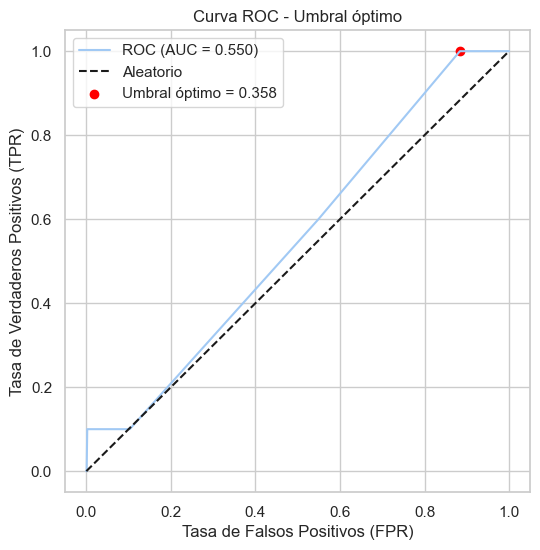

In [158]:
from sklearn.metrics import roc_curve, auc

# Curva ROC y umbral óptimo
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
umbral_optimo = thresholds[np.argmax(tpr - fpr)]
print(f"🔹 Umbral óptimo (ROC): {umbral_optimo:.3f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--", label="Aleatorio")
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], 
            color="red", label=f"Umbral óptimo = {umbral_optimo:.3f}")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Umbral óptimo")
plt.legend()
plt.show()


In [159]:
# Predicciones usando el umbral óptimo
y_pred_opt = (probs >= umbral_optimo).astype(int)

print("\n✅ MATRIZ DE CONFUSIÓN (umbral óptimo)")
print(confusion_matrix(y_test, y_pred_opt))
print("\nREPORTE DE CLASIFICACIÓN (umbral óptimo)")
print(classification_report(y_test, y_pred_opt))


✅ MATRIZ DE CONFUSIÓN (umbral óptimo)
[[ 162 1231]
 [   0   10]]

REPORTE DE CLASIFICACIÓN (umbral óptimo)
              precision    recall  f1-score   support

           0       1.00      0.12      0.21      1393
           1       0.01      1.00      0.02        10

    accuracy                           0.12      1403
   macro avg       0.50      0.56      0.11      1403
weighted avg       0.99      0.12      0.21      1403



7.2.4. Umbral que maximiza el F1 Score

In [160]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
umbral_f1_optimo = thresholds[np.argmax(f1_scores)]
print(f"🔹 Umbral que maximiza F1-score: {umbral_f1_optimo:.3f}")
print(f"🔹 F1-score máximo alcanzado: {np.max(f1_scores):.3f}")

🔹 Umbral que maximiza F1-score: 0.667
🔹 F1-score máximo alcanzado: 0.143


In [161]:
# --- Evaluación del modelo con ese umbral ---
y_pred_opt = (probs >= umbral_f1_optimo).astype(int)

In [162]:
y_pred_f1_opt = (probs >= umbral_f1_optimo).astype(int)
print("\n✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)")
print(confusion_matrix(y_test, y_pred_f1_opt))
print("\n📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)")
print(classification_report(y_test, y_pred_f1_opt))


✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)
[[1390    3]
 [   9    1]]

📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1393
           1       0.25      0.10      0.14        10

    accuracy                           0.99      1403
   macro avg       0.62      0.55      0.57      1403
weighted avg       0.99      0.99      0.99      1403



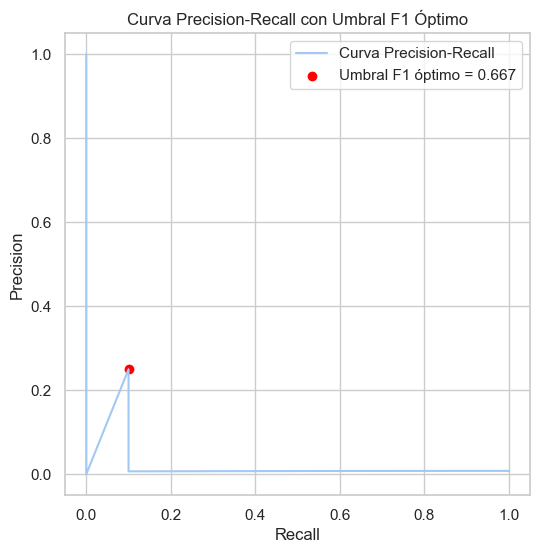

In [163]:
plt.figure(figsize=(6,6))
plt.plot(rec, prec, label="Curva Precision-Recall")
plt.scatter(rec[np.argmax(f1_scores)], prec[np.argmax(f1_scores)],
            color="red", label=f"Umbral F1 óptimo = {umbral_f1_optimo:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall con Umbral F1 Óptimo")
plt.legend()
plt.grid(True)
plt.show()

📊 Resultados comparativos:


,Modelo,Accuracy,Precision,Recall,F1-Score,AUC
0,Sin balanceo,0.992,0.000,0.0,0.000,0.548
1,Oversampling,0.892,0.007,0.1,0.013,0.550
2,SMOTE,0.890,0.000,0.0,0.000,0.494
3,Class_weight (0.5),0.892,0.007,0.1,0.013,0.550
4,Class_weight (ROC óptimo),0.991,0.250,0.1,0.143,0.550
5,Class_weight (F1 óptimo),0.991,0.250,0.1,0.143,0.550


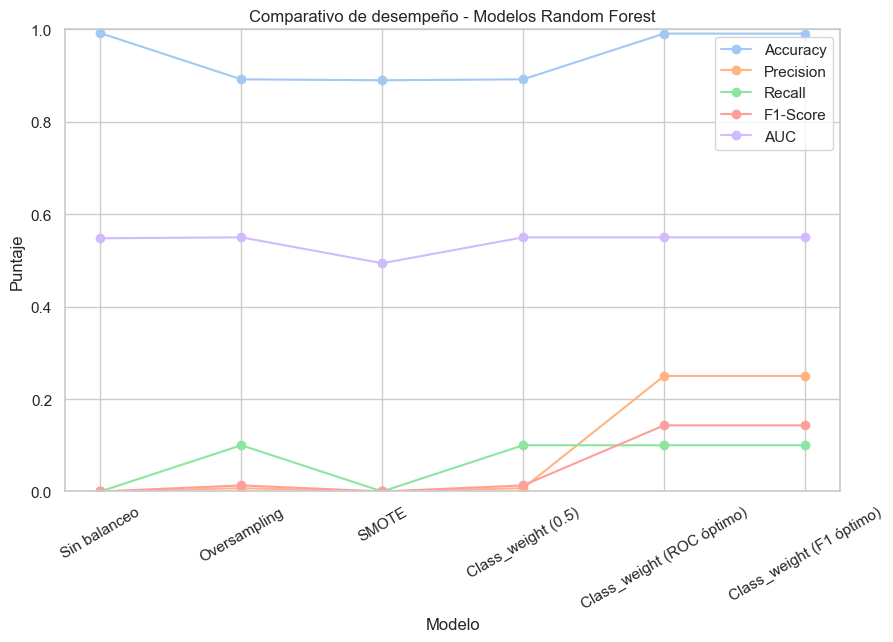

In [164]:
# ============================================================
# 8. COMPARATIVO DE DESEMPEÑO DE MODELOS RANDOM FOREST
# ============================================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import pandas as pd
import matplotlib.pyplot as plt

# Calculamos métricas de todos los modelos
resultados = []

def evaluar_modelo(nombre, y_true, y_pred, probs=None):
    """Función para calcular métricas básicas y guardar resultados."""
    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_true, probs) if probs is not None else np.nan
    })

# --- 1️⃣ Sin balanceo ---
evaluar_modelo("Sin balanceo", y_test, y_pred, modelo_rf.predict_proba(X_test)[:,1])

# --- 2️⃣ Oversampling ---
evaluar_modelo("Oversampling", y_test, y_pred_ros, modelo_rf_ros.predict_proba(X_test)[:,1])

# --- 3️⃣ SMOTE ---
evaluar_modelo("SMOTE", y_test, y_pred_sm, modelo_rf_sm.predict_proba(X_test)[:,1])

# --- 4️⃣ class_weight balanced (umbral 0.5) ---
evaluar_modelo("Class_weight (0.5)", y_test, y_pred_default, probs)

# --- 5️⃣ class_weight balanced (umbral ROC óptimo) ---
evaluar_modelo("Class_weight (ROC óptimo)", y_test, y_pred_opt, probs)

# --- 6️⃣ class_weight balanced (umbral F1 óptimo) ---
evaluar_modelo("Class_weight (F1 óptimo)", y_test, y_pred_f1_opt, probs)

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados).round(3)

# Mostrar resultados
print("📊 Resultados comparativos:")
display(df_resultados)

# ============================================================
# 8.1. Visualización comparativa
# ============================================================
plt.figure(figsize=(10,6))
for metric in ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]:
    plt.plot(df_resultados["Modelo"], df_resultados[metric], marker="o", label=metric)

plt.title("Comparativo de desempeño - Modelos Random Forest")
plt.xlabel("Modelo")
plt.ylabel("Puntaje")
plt.xticks(rotation=30)
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()


MODELOS CON MÁS VARIABLES

In [165]:
df_modelo = df2[[
    "FechaSeguimiento_DT", 
    "Causa_DS", 
    "AgenteGenerador_DS", 
    "Severidad_NUM", 
    "valor_acumulado", 
    "materializado_30d"
]].copy()

In [166]:
# --- 2. Variables temporales ---
df_modelo["FechaSeguimiento_DT"] = pd.to_datetime(df_modelo["FechaSeguimiento_DT"])
df_modelo["mes"] = df_modelo["FechaSeguimiento_DT"].dt.month
df_modelo["anio"] = df_modelo["FechaSeguimiento_DT"].dt.year

In [167]:
# --- 3. Codificación de variables categóricas ---
le_causa = LabelEncoder()
le_agente = LabelEncoder()

df_modelo["Causa_DS"] = le_causa.fit_transform(df_modelo["Causa_DS"].astype(str))
df_modelo["AgenteGenerador_DS"] = le_agente.fit_transform(df_modelo["AgenteGenerador_DS"].astype(str))

In [168]:
# --- 4. Variables finales ---
X_2 = df_modelo[[
    "Causa_DS", 
    "AgenteGenerador_DS", 
    "mes", 
    "anio", 
    "Severidad_NUM", 
    "valor_acumulado"
]]
y_2 = df_modelo["materializado_30d"]

In [169]:
# --- 5. División de datos ---
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2, y_2, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_2  # mantiene la proporción de clases
)

print("Tamaño entrenamiento:", X_train_2.shape)
print("Tamaño prueba:", X_test_2.shape)
print("Distribución en y_train_2:")
print(y_train_2.value_counts(normalize=True))

Tamaño entrenamiento: (5610, 6)
Tamaño prueba: (1403, 6)
Distribución en y_train_2:
materializado_30d
0    0.993048
1    0.006952
Name: proportion, dtype: float64


8. Random Forest

In [170]:
# --- 6. Entrenar Random Forest con balanceo ---
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    max_depth=None,
    min_samples_leaf=2
)
rf.fit(X_train_2, y_train_2)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [171]:
probs_rf = rf.predict_proba(X_test_2)[:, 1]

In [172]:
# --- 8. Umbral óptimo por curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test_2, probs_rf)
roc_auc = auc(fpr, tpr)

umbral_roc = thresholds[np.argmax(tpr - fpr)]
print(f"\n🔹 Umbral óptimo ROC = {umbral_roc:.3f}")


🔹 Umbral óptimo ROC = 0.073


In [173]:
# --- 9. Umbral óptimo por F1 ---
precision, recall, thresholds_f1 = precision_recall_curve(y_test_2, probs_rf)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
umbral_f1 = thresholds_f1[np.argmax(f1_scores)]
print(f"🔹 Umbral óptimo F1 = {umbral_f1:.3f}")

🔹 Umbral óptimo F1 = 0.525


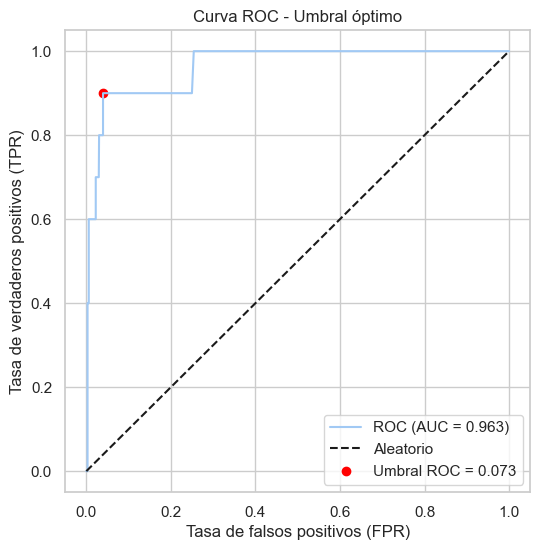

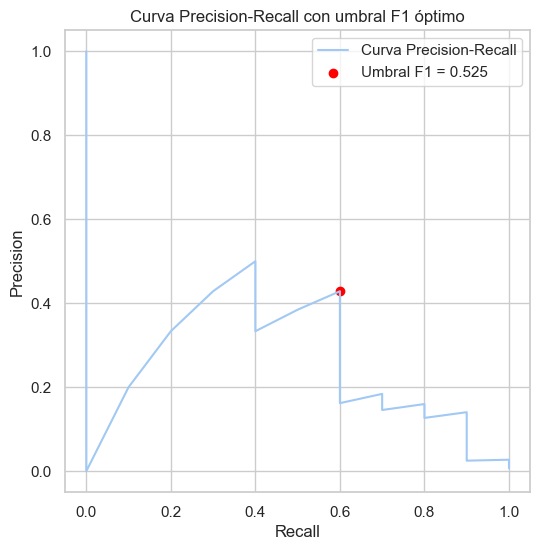

In [174]:
# --- 10. Gráficos de curvas ---
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', label="Aleatorio")
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], 
            color='red', label=f"Umbral ROC = {umbral_roc:.3f}")
plt.title("Curva ROC - Umbral óptimo")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label="Curva Precision-Recall")
plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], 
            color='red', label=f"Umbral F1 = {umbral_f1:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall con umbral F1 óptimo")
plt.legend()
plt.show()

In [175]:
# --- 11. Predicciones con umbral F1 óptimo ---
y_pred_opt2 = (probs_rf >= umbral_f1).astype(int)

In [176]:
print("\n✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)")
print(confusion_matrix(y_test_2, y_pred_opt2))

print("\n📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)")
print(classification_report(y_test_2, y_pred_opt2))


✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)
[[1385    8]
 [   4    6]]

📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1393
           1       0.43      0.60      0.50        10

    accuracy                           0.99      1403
   macro avg       0.71      0.80      0.75      1403
weighted avg       0.99      0.99      0.99      1403



In [177]:
verdaderos_positivos = np.sum((y_pred_opt2 == 1) & (y_test_2 == 1))
total_positivos = np.sum(y_test_2 == 1)
tasa_deteccion_temprana = (verdaderos_positivos / total_positivos) * 100
print(f"Tasa de detección temprana: {tasa_deteccion_temprana:.2f}%")

Tasa de detección temprana: 60.00%


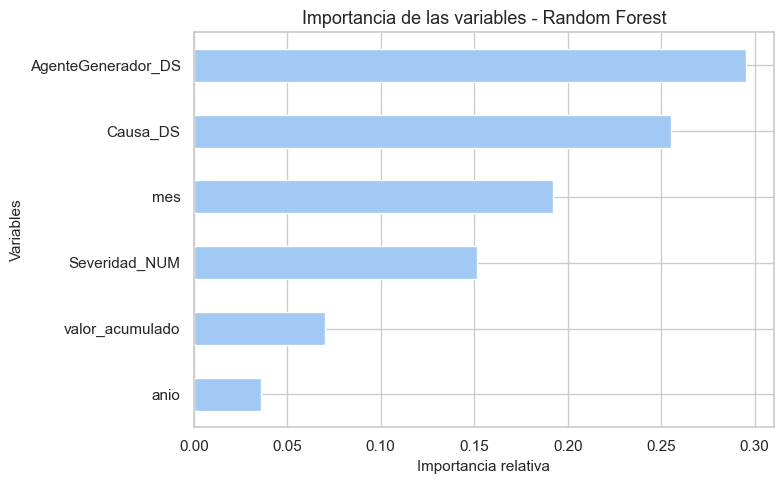

In [178]:
importances_rf = pd.Series(rf.feature_importances_, index=X_2.columns)
importances_rf.sort_values(ascending=True).plot(
    kind='barh', 
    figsize=(8, 5)
)

plt.title("Importancia de las variables - Random Forest", fontsize=13)
plt.xlabel("Importancia relativa", fontsize=11)
plt.ylabel("Variables", fontsize=11)
plt.tight_layout()
plt.show()

In [179]:
print(f"AUC final Random Forest: {roc_auc:.3f}")

AUC final Random Forest: 0.963


In [180]:
#Guardar el modelo

import joblib
joblib.dump(rf, "modelo_rf_materializacion.pkl")

['modelo_rf_materializacion.pkl']

9. Modelo GBoost

In [181]:
df_gb = df_modelo.copy()

In [182]:
from sklearn.ensemble import GradientBoostingClassifier

modelo_gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
modelo_gb.fit(X_train_2, y_train_2)

,loss,'log_loss'
,learning_rate,0.05
,n_estimators,300
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [183]:
probs_gb = modelo_gb.predict_proba(X_test_2)[:, 1]

In [184]:
fpr, tpr, thresholds = roc_curve(y_test_2, probs_gb)
roc_auc = auc(fpr, tpr)

# Umbral óptimo (maximiza TPR - FPR)
umbral_optimo = thresholds[np.argmax(tpr - fpr)]
print(f"🔹 Umbral óptimo encontrado: {umbral_optimo:.3f}")

🔹 Umbral óptimo encontrado: 0.023


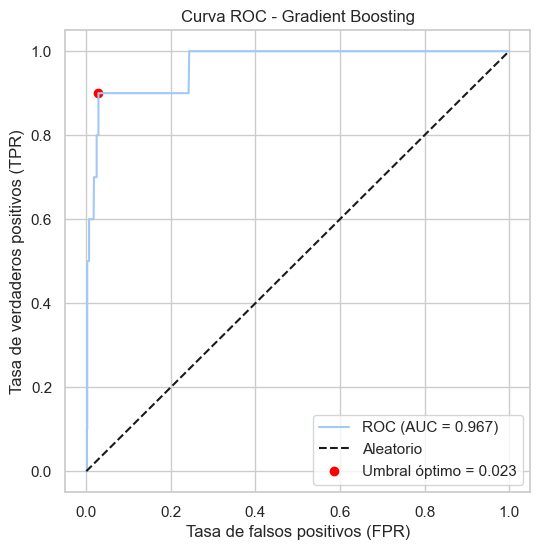

In [185]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--", label="Aleatorio")
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], 
            color="red", label=f"Umbral óptimo = {umbral_optimo:.3f}")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC - Gradient Boosting")
plt.legend()
plt.show()

In [186]:
pred_opt_gb = (probs_gb >= umbral_optimo).astype(int)

In [187]:
print("\n✅ MATRIZ DE CONFUSIÓN (umbral óptimo)")
print(confusion_matrix(y_test_2, pred_opt_gb))

print("\n📊 REPORTE DE CLASIFICACIÓN (umbral óptimo)")
print(classification_report(y_test_2, pred_opt_gb))


✅ MATRIZ DE CONFUSIÓN (umbral óptimo)
[[1353   40]
 [   1    9]]

📊 REPORTE DE CLASIFICACIÓN (umbral óptimo)
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1393
           1       0.18      0.90      0.31        10

    accuracy                           0.97      1403
   macro avg       0.59      0.94      0.65      1403
weighted avg       0.99      0.97      0.98      1403



In [188]:
import joblib
joblib.dump(modelo_gb, "modelo_gradientboosting.pkl")

['modelo_gradientboosting.pkl']

8.1. Mejor tradeoff

🔹 Umbral con mejor F1-score: 0.478
🔹 F1 máximo alcanzado: 0.556


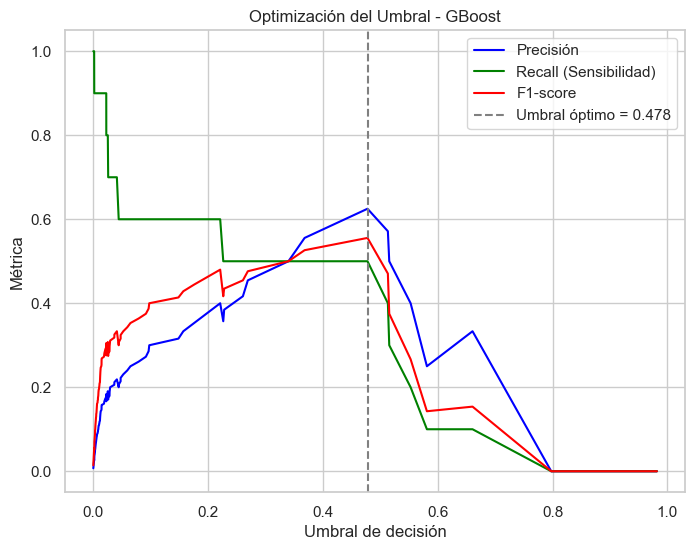

In [189]:
# Probabilidades predichas por el modelo
probs_gb = modelo_gb.predict_proba(X_test_2)[:, 1]

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test_2, probs_gb)

# Calcular F1 para cada umbral
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Encontrar el umbral con el F1 máximo
umbral_f1_optimo = thresholds[np.argmax(f1_scores)]
print(f"🔹 Umbral con mejor F1-score: {umbral_f1_optimo:.3f}")
print(f"🔹 F1 máximo alcanzado: {np.max(f1_scores):.3f}")

# Graficar curvas
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisión", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall (Sensibilidad)", color="green")
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color="red")
plt.axvline(x=umbral_f1_optimo, color="gray", linestyle="--", label=f"Umbral óptimo = {umbral_f1_optimo:.3f}")
plt.xlabel("Umbral de decisión")
plt.ylabel("Métrica")
plt.title("Optimización del Umbral - GBoost")
plt.legend()
plt.grid(True)
plt.show()

Usaremos el umbral óptimo 0.4

In [190]:
umbral_optimo = float(np.round(umbral_f1_optimo, 3))

In [191]:
# 🔹 Probabilidades predichas por el modelo GBoost
probs_gb = modelo_gb.predict_proba(X_test_2)[:, 1]

# 🔹 Aplicar el umbral óptimo
umbral_optimo = 0.403
pred_opt2_gb = (probs_gb >= umbral_optimo).astype(int)

# 🔹 Calcular matriz de confusión y reporte
matriz_gb = confusion_matrix(y_test_2, pred_opt2_gb)
reporte_gb = classification_report(y_test_2, pred_opt2_gb, digits=3)

# 🔹 Mostrar resultados
print("✅ MATRIZ DE CONFUSIÓN (umbral óptimo = 0.403)")
print(matriz_gb)
print("\n📊 REPORTE DE CLASIFICACIÓN (umbral óptimo = 0.403)")
print(reporte_gb)

✅ MATRIZ DE CONFUSIÓN (umbral óptimo = 0.403)
[[1390    3]
 [   5    5]]

📊 REPORTE DE CLASIFICACIÓN (umbral óptimo = 0.403)
              precision    recall  f1-score   support

           0      0.996     0.998     0.997      1393
           1      0.625     0.500     0.556        10

    accuracy                          0.994      1403
   macro avg      0.811     0.749     0.776      1403
weighted avg      0.994     0.994     0.994      1403



In [192]:
df_modelo["Riesgo_CD"] = df2["Riesgo_CD"].values

In [193]:
resultados_rf = pd.DataFrame({
    "Riesgo_CD": df_modelo.loc[y_test_2.index, "Riesgo_CD"],
    "Prob_Materializacion": probs_rf,
    "Predicho_Materializado": y_pred_opt2,   # usa el nombre correcto de tus predicciones
    "Real_Materializado": y_test_2.values
})

# --- Guardar resultados ---
resultados_rf.to_excel("Predicciones_Modelo_RF_optimo.xlsx", index=False)
print("✅ Archivo 'Predicciones_Modelo_RF_optimo.xlsx' creado exitosamente.")

✅ Archivo 'Predicciones_Modelo_RF_optimo.xlsx' creado exitosamente.


9. Modelo XGBoost

In [194]:
X_train_xgb = X_train_2.copy()
X_test_xgb = X_test_2.copy()

In [195]:
# Convertir columnas categóricas a códigos numéricos
X_train_xgb = X_train_xgb.apply(lambda col: col.cat.codes if str(col.dtype) == 'category' else col)
X_test_xgb = X_test_xgb.apply(lambda col: col.cat.codes if str(col.dtype) == 'category' else col)

In [196]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=10,
    eval_metric='logloss'
)

xgb_model.fit(X_train_xgb, y_train_2)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [197]:
probs_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_2, probs_xgb)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

umbral_f1_optimo = thresholds[np.argmax(f1_scores)]
f1_maximo = np.max(f1_scores)

print(f"🔹 Umbral con mejor F1-score: {umbral_f1_optimo:.3f}")
print(f"🔹 F1 máximo alcanzado: {f1_maximo:.3f}")

🔹 Umbral con mejor F1-score: 0.821
🔹 F1 máximo alcanzado: 0.444


In [198]:
pred_opt_xgb = (probs_xgb >= umbral_f1_optimo).astype(int)

matriz_xgb = confusion_matrix(y_test_2, pred_opt_xgb)
reporte_xgb = classification_report(y_test_2, pred_opt_xgb, digits=3)

print("\n✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)")
print(matriz_xgb)

print("\n📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)")
print(reporte_xgb)


✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)
[[1389    4]
 [   6    4]]

📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)
              precision    recall  f1-score   support

           0      0.996     0.997     0.996      1393
           1      0.500     0.400     0.444        10

    accuracy                          0.993      1403
   macro avg      0.748     0.699     0.720      1403
weighted avg      0.992     0.993     0.992      1403



In [199]:
# Crear DataFrame con las predicciones y probabilidades
resultados_xgb = pd.DataFrame({
    "Riesgo_CD": df_modelo.loc[y_test_2.index, "Riesgo_CD"],
    "Prob_Materializacion": probs_xgb,
    "Predicho_Materializado": pred_opt_xgb,
    "Real_Materializado": y_test_2.values
})

In [200]:
nombre_archivo = "Predicciones_Modelo_XGBoost_optimo.xlsx"
resultados_xgb.to_excel(nombre_archivo, index=False)

print(f"✅ Archivo '{nombre_archivo}' creado exitosamente.")

✅ Archivo 'Predicciones_Modelo_XGBoost_optimo.xlsx' creado exitosamente.


10. Modelo lightgbm con encoding interno

In [201]:
categorical_features = ["Causa_DS", "AgenteGenerador_DS"]

In [202]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"
)

lgbm_model.fit(
    X_train_2, y_train_2,
    categorical_feature=categorical_features
)

[LightGBM] [Info] Number of positive: 39, number of negative: 5571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 5610, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [203]:
probs_lgbm = lgbm_model.predict_proba(X_test_2)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_2, probs_lgbm)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

umbral_f1_optimo = thresholds[np.argmax(f1_scores)]
print(f"🔹 Umbral F1 óptimo: {umbral_f1_optimo:.3f}")
print(f"🔹 F1 máximo: {np.max(f1_scores):.3f}")

🔹 Umbral F1 óptimo: 0.710
🔹 F1 máximo: 0.273


In [204]:
pred_opt_lgbm = (probs_lgbm >= umbral_f1_optimo).astype(int)

In [205]:
matriz_lgbm = confusion_matrix(y_test_2, pred_opt_lgbm)
reporte_lgbm = classification_report(y_test_2, pred_opt_lgbm, digits=3)

print("\n✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)")
print(matriz_lgbm)
print("\n📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)")
print(reporte_lgbm)


✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)
[[1384    9]
 [   7    3]]

📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)
              precision    recall  f1-score   support

           0      0.995     0.994     0.994      1393
           1      0.250     0.300     0.273        10

    accuracy                          0.989      1403
   macro avg      0.622     0.647     0.633      1403
weighted avg      0.990     0.989     0.989      1403



11. Modelo ligthgbm usando label encoding

In [206]:
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"
)

lgbm.fit(X_train_2, y_train_2)

[LightGBM] [Info] Number of positive: 39, number of negative: 5571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 5610, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [207]:
probs2_lgbm = lgbm.predict_proba(X_test_2)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_2, probs2_lgbm)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

umbral_f1_optimo = thresholds[np.argmax(f1_scores)]
print(f"🔹 Umbral F1 óptimo: {umbral_f1_optimo:.3f}")
print(f"🔹 F1 máximo: {np.max(f1_scores):.3f}")

🔹 Umbral F1 óptimo: 0.988
🔹 F1 máximo: 0.471


In [208]:
pred_opt_lgbm2 = (probs2_lgbm >= umbral_f1_optimo).astype(int)

In [209]:
matriz_lgbm2 = confusion_matrix(y_test_2, pred_opt_lgbm2)
reporte_lgbm2 = classification_report(y_test_2, pred_opt_lgbm2, digits=3)

print("\n✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)")
print(matriz_lgbm2)
print("\n📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)")
print(reporte_lgbm2)


✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)
[[1390    3]
 [   6    4]]

📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)
              precision    recall  f1-score   support

           0      0.996     0.998     0.997      1393
           1      0.571     0.400     0.471        10

    accuracy                          0.994      1403
   macro avg      0.784     0.699     0.734      1403
weighted avg      0.993     0.994     0.993      1403



In [210]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# --- Crear diccionario con métricas por modelo ---
resultados_finales = []

# Random Forest
resultados_finales.append({
    "Modelo": "Random Forest",
    "Accuracy": accuracy_score(y_test_2, y_pred_opt2),
    "Precision": precision_score(y_test_2, y_pred_opt2, zero_division=0),
    "Recall": recall_score(y_test_2, y_pred_opt2, zero_division=0),
    "F1-Score": f1_score(y_test_2, y_pred_opt2, zero_division=0),
    "AUC": roc_auc_score(y_test_2, probs_rf)
})

# Gradient Boosting
resultados_finales.append({
    "Modelo": "Gradient Boosting",
    "Accuracy": accuracy_score(y_test_2, pred_opt2_gb),
    "Precision": precision_score(y_test_2, pred_opt2_gb, zero_division=0),
    "Recall": recall_score(y_test_2, pred_opt2_gb, zero_division=0),
    "F1-Score": f1_score(y_test_2, pred_opt2_gb, zero_division=0),
    "AUC": roc_auc_score(y_test_2, probs_gb)
})

# XGBoost
resultados_finales.append({
    "Modelo": "XGBoost",
    "Accuracy": accuracy_score(y_test_2, pred_opt_xgb),
    "Precision": precision_score(y_test_2, pred_opt_xgb, zero_division=0),
    "Recall": recall_score(y_test_2, pred_opt_xgb, zero_division=0),
    "F1-Score": f1_score(y_test_2, pred_opt_xgb, zero_division=0),
    "AUC": roc_auc_score(y_test_2, probs_xgb)
})

# LightGBM
resultados_finales.append({
    "Modelo": "LightGBM",
    "Accuracy": accuracy_score(y_test_2, pred_opt_lgbm2),
    "Precision": precision_score(y_test_2, pred_opt_lgbm2, zero_division=0),
    "Recall": recall_score(y_test_2, pred_opt_lgbm2, zero_division=0),
    "F1-Score": f1_score(y_test_2, pred_opt_lgbm2, zero_division=0),
    "AUC": roc_auc_score(y_test_2, probs2_lgbm)
})

# --- Convertimos a DataFrame ---
df_resultados_finales = pd.DataFrame(resultados_finales)

# --- Redondeamos a 3 decimales ---
df_resultados_finales = df_resultados_finales.round(3)

print("\n📊 RESULTADOS COMPARATIVOS FINALES:")
display(df_resultados_finales)




📊 RESULTADOS COMPARATIVOS FINALES:


,Modelo,Accuracy,Precision,Recall,F1-Score,AUC
0,Random Forest,0.991,0.429,0.6,0.500,0.963
1,Gradient Boosting,0.994,0.625,0.5,0.556,0.967
2,XGBoost,0.993,0.500,0.4,0.444,0.940
3,LightGBM,0.994,0.571,0.4,0.471,0.949


NUEVA VERSIÓN CON DIFERENTES VARIABLES

In [211]:
# --- 1. Copiar el DataFrame base ---
df_modelo_v2 = df2[[
    "FechaSeguimiento_DT", 
    "Causa_DS", 
    "AgenteGenerador_DS", 
    "Severidad_NUM", 
    "materializado_30d",
    "valor_acumulado", 
    "Riesgo_CD"  # Necesario para guardar resultados después
]].copy()

In [212]:
# --- 2. Procesar fecha ---
df_modelo_v2["FechaSeguimiento_DT"] = pd.to_datetime(df_modelo_v2["FechaSeguimiento_DT"])
df_modelo_v2["anio"] = df_modelo_v2["FechaSeguimiento_DT"].dt.year

In [213]:
# --- 3. Codificación de variables categóricas ---
from sklearn.preprocessing import LabelEncoder

le_causa_v2 = LabelEncoder()
le_agente_v2 = LabelEncoder()

df_modelo_v2["Causa_DS"] = le_causa_v2.fit_transform(df_modelo_v2["Causa_DS"].astype(str))
df_modelo_v2["AgenteGenerador_DS"] = le_agente_v2.fit_transform(df_modelo_v2["AgenteGenerador_DS"].astype(str))


In [215]:
# --- 4. Variables finales ---
X_v2 = df_modelo_v2[[
    "Causa_DS", 
    "AgenteGenerador_DS", 
    "Severidad_NUM", 
    "anio",
    "valor_acumulado"
]]
y_v2 = df_modelo_v2["materializado_30d"]


In [216]:
# --- 5. División de datos ---
from sklearn.model_selection import train_test_split

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2, y_v2, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_v2
)

# --- 5b. Convertir columnas category a numéricas (para XGBoost) ---
for col in X_train_v2.columns:
    if str(X_train_v2[col].dtype) == 'category':
        X_train_v2[col] = X_train_v2[col].cat.codes
        X_test_v2[col] = X_test_v2[col].cat.codes

print("Tamaño entrenamiento:", X_train_v2.shape)
print("Tamaño prueba:", X_test_v2.shape)
print("Distribución en y_train_v2:")
print(y_train_v2.value_counts(normalize=True))

Tamaño entrenamiento: (5610, 5)
Tamaño prueba: (1403, 5)
Distribución en y_train_v2:
materializado_30d
0    0.993048
1    0.006952
Name: proportion, dtype: float64


In [217]:

# --- 6. Definir modelos a entrenar ---
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

modelos_v2 = {
    "RandomForest_v2": RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced",
        max_depth=None, min_samples_leaf=2
    ),
    "GradientBoosting_v2": GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
    ),
    "XGBoost_v2": XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.8,
        colsample_bytree=0.8, random_state=42, scale_pos_weight=10,
        eval_metric='logloss'
    ),
    "LightGBM_v2": LGBMClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=-1, num_leaves=31,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        class_weight="balanced"
    )
}

In [218]:
# --- 7. Función para entrenar y evaluar ---
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
import numpy as np

def entrenar_evaluar(modelo, X_train, y_train, X_test, y_test, nombre_modelo, umbral_fijo=None):
    """
    Entrena un modelo, calcula probabilidades, encuentra umbral óptimo por F1
    y devuelve predicciones, probabilidades y umbral usado.
    """
    # Entrenar
    modelo.fit(X_train, y_train)
    
    # Probabilidades
    probs = modelo.predict_proba(X_test)[:, 1]
    
    # Umbral óptimo por F1
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    umbral_f1 = thresholds[np.argmax(f1_scores)]
    
    # Si se pasa un umbral fijo, usarlo
    if umbral_fijo is not None:
        umbral_f1 = umbral_fijo
    
    # Predicciones binarias
    y_pred = (probs >= umbral_f1).astype(int)
    
    # Métricas
    auc_score = roc_auc_score(y_test, probs)
    f1_score_val = f1_score(y_test, y_pred)
    matriz = confusion_matrix(y_test, y_pred)
    reporte = classification_report(y_test, y_pred, digits=3)
    
    print(f"\n✅ {nombre_modelo} - Umbral usado: {umbral_f1:.3f}")
    print("AUC:", round(auc_score,3), "| F1:", round(f1_score_val,3))
    print("Matriz de Confusión:\n", matriz)
    print("\nReporte de Clasificación:\n", reporte)
    
    return y_pred, probs, umbral_f1


In [219]:
# --- 8. Entrenar y evaluar todos los modelos depurados ---
resultados_v2 = {}

for nombre, modelo in modelos_v2.items():
    y_pred, probs, umbral = entrenar_evaluar(
        modelo, X_train_v2, y_train_v2, X_test_v2, y_test_v2, nombre
    )
    resultados_v2[nombre] = {
        "y_pred": y_pred,
        "probs": probs,
        "umbral": umbral
    }


✅ RandomForest_v2 - Umbral usado: 0.974
AUC: 0.902 | F1: 0.526
Matriz de Confusión:
 [[1389    4]
 [   5    5]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0      0.996     0.997     0.997      1393
           1      0.556     0.500     0.526        10

    accuracy                          0.994      1403
   macro avg      0.776     0.749     0.762      1403
weighted avg      0.993     0.994     0.993      1403


✅ GradientBoosting_v2 - Umbral usado: 0.330
AUC: 0.926 | F1: 0.5
Matriz de Confusión:
 [[1385    8]
 [   4    6]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0      0.997     0.994     0.996      1393
           1      0.429     0.600     0.500        10

    accuracy                          0.991      1403
   macro avg      0.713     0.797     0.748      1403
weighted avg      0.993     0.991     0.992      1403


✅ XGBoost_v2 - Umbral usado: 0.820
AUC: 0.913 | F1: 0.5
Matri

In [220]:
# --- 9. Guardar resultados en Excel ---
import pandas as pd

for nombre, res in resultados_v2.items():
    df_result = pd.DataFrame({
        "Riesgo_CD": df_modelo_v2.loc[y_test_v2.index, "Riesgo_CD"],
        "Prob_Materializacion": res["probs"],
        "Predicho_Materializado": res["y_pred"],
        "Real_Materializado": y_test_v2.values
    })
    df_result.to_excel(f"Predicciones_{nombre}_v2.xlsx", index=False)
    print(f"✅ Archivo 'Predicciones_{nombre}_v2.xlsx' creado.")

✅ Archivo 'Predicciones_RandomForest_v2_v2.xlsx' creado.
✅ Archivo 'Predicciones_GradientBoosting_v2_v2.xlsx' creado.
✅ Archivo 'Predicciones_XGBoost_v2_v2.xlsx' creado.
✅ Archivo 'Predicciones_LightGBM_v2_v2.xlsx' creado.


In [221]:
# ============================
# RESUMEN COMPARATIVO DE MODELOS
# ============================

from sklearn.metrics import roc_auc_score, f1_score

# Crear diccionario para almacenar métricas
resumen_modelos = {}

# --- Modelos anteriores (completo) ---
# Suponiendo que ya tienes: rf, modelo_gb, xgb_model, lgbm
modelos_completos = {
    "RF_completo": rf,
    "GB_completo": modelo_gb,
    "XGB_completo": xgb_model,
    "LGBM_completo": lgbm
}

X_tests_completos = {
    "RF_completo": X_test_2,
    "GB_completo": X_test_2,
    "XGB_completo": X_test_xgb,  # ya convertido a numérico si es necesario
    "LGBM_completo": X_test_2
}

y_tests_completos = {
    "RF_completo": y_test_2,
    "GB_completo": y_test_2,
    "XGB_completo": y_test_2,
    "LGBM_completo": y_test_2
}

for nombre, modelo in modelos_completos.items():
    probs = modelo.predict_proba(X_tests_completos[nombre])[:,1]
    y_pred = (probs >= 0.403).astype(int)  # si quieres usar un umbral fijo
    resumen_modelos[nombre] = {
        "AUC": roc_auc_score(y_tests_completos[nombre], probs),
        "F1": f1_score(y_tests_completos[nombre], y_pred)
    }

# --- Modelos depurados (_v2) ---
for nombre, res in resultados_v2.items():
    resumen_modelos[nombre] = {
        "AUC": roc_auc_score(y_test_v2, res["probs"]),
        "F1": f1_score(y_test_v2, res["y_pred"])
    }

# --- Crear DataFrame de resumen ---
df_resumen = pd.DataFrame(resumen_modelos).T
df_resumen = df_resumen.sort_values(by="AUC", ascending=False)

print("\n📊 RESUMEN DE MODELOS (AUC y F1)")
display(df_resumen)

# --- Guardar resumen en Excel ---
df_resumen.to_excel("Resumen_Modelos_Comparativo.xlsx")
print("\n✅ Archivo 'Resumen_Modelos_Comparativo.xlsx' creado exitosamente.")



📊 RESUMEN DE MODELOS (AUC y F1)


,AUC,F1
GB_completo,0.967014,0.555556
RF_completo,0.963352,0.413793
LGBM_completo,0.949103,0.437500
XGB_completo,0.939519,0.357143
GradientBoosting_v2,0.926095,0.500000
XGBoost_v2,0.912814,0.500000
RandomForest_v2,0.902225,0.526316
LightGBM_v2,0.891350,0.454545



✅ Archivo 'Resumen_Modelos_Comparativo.xlsx' creado exitosamente.
